In [1]:
%load_ext autoreload
%autoreload 2

In [174]:
import pandas as pd
import numpy as np
import sys, logging
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import re

sys.path.append("../../src/")
from turnstile import turnstile

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

%matplotlib inline

In [3]:
def get_trips(trips,stop_times,weekday=True):
    trip = pd.read_csv(trips)
    stop_time = pd.read_csv(stop_times)
    weekday = stop_time[stop_time.trip_id.str.contains('Weekday')]
    weekday = weekday.merge(trip[['trip_id','route_id','direction_id']],how='left',on='trip_id')
    return weekday
    

In [629]:
apr_weekday = pd.read_csv('data/weekday_gtfs_0420_0424.csv')
apr_weekend = pd.read_csv('data/wekend_gtfs_0418-0419_0425-0426.csv')

jan_weekday = get_trips('data/gtfs_9Jan/trips.txt','data/gtfs_9Jan/stop_times.txt')
may_weekday = get_trips('data/gtfs_30Apr/trips.txt','data/gtfs_30Apr/stop_times.txt')

In [262]:
jan_weekday.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,direction_id
0,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:06:30,00:06:30,101S,1,NaN,0,0,NaN,1,1
1,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:08:00,00:08:00,103S,2,NaN,0,0,NaN,1,1
2,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:09:30,00:09:30,104S,3,NaN,0,0,NaN,1,1
3,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:11:00,00:11:00,106S,4,NaN,0,0,NaN,1,1
4,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:12:30,00:12:30,107S,5,NaN,0,0,NaN,1,1


In [263]:
apr_weekday.head()

,current_status,current_stop_sequence,route_id,start_date,start_time,stop_id,stop_name,timestamp,trip_id
0,1.0,25.0,1,20200419,NaN,116N,125 St,2020-04-19 23:59:38,116450_1..N03R
1,1.0,6.0,1,20200419,NaN,135N,Canal St,2020-04-19 23:59:45,119450_1..N03R
2,1.0,24.0,3,20200419,NaN,132N,14 St,2020-04-19 23:59:44,115900_3..N05X002
3,1.0,11.0,3,20200419,NaN,239N,Franklin Av,2020-04-19 23:59:39,118400_3..N05X002
4,1.0,4.0,3,20200419,NaN,254N,Junius St,2020-04-19 23:59:47,119600_3..N05X002


In [264]:
may_weekday.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,direction_id
0,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:06:30,00:06:30,101S,1,NaN,0,0,NaN,1,1
1,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:08:00,00:08:00,103S,2,NaN,0,0,NaN,1,1
2,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:09:30,00:09:30,104S,3,NaN,0,0,NaN,1,1
3,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:11:00,00:11:00,106S,4,NaN,0,0,NaN,1,1
4,AFA19GEN-1087-Weekday-00_000650_1..S03R,00:12:30,00:12:30,107S,5,NaN,0,0,NaN,1,1


In [630]:
jan_weekday['trimmed_stop_id'] = [re.sub(r'(N|S)$','',x) for x in jan_weekday.stop_id]
jan_weekday.route_id.value_counts().head()

1    17400
F    17065
2    16289
6    15340
A    12825
Name: route_id, dtype: int64

In [266]:
apr_weekday.route_id.value_counts()

A     105231
F      84818
D      82496
R      72852
N      67685
Q      66426
M      57959
J      56420
2      52987
7      46683
E      44831
G      42596
6      38811
1      37650
4      35331
3      22830
5      15931
H       6915
FS      6510
W         27
Name: route_id, dtype: int64

In [267]:
may_weekday.route_id.value_counts().head()

1    17400
F    17065
2    16289
6    15340
L    12892
Name: route_id, dtype: int64

In [268]:
merged = jan_weekday.merge(may_weekday,indicator=True,how='outer',on=['arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'stop_headsign', 'pickup_type', 'drop_off_type', 'shape_dist_traveled',
       'route_id', 'direction_id'])

In [269]:
merged[merged._merge != 'both'].route_id.value_counts()

L    5002
G    2932
M    2498
F     754
Name: route_id, dtype: int64

**Notes:**
- 30th Apr MTA static GTFS data seems to be the same as the Jan data with some schedule changes to L,G,M, and F lines. Still seems to include some trips on lines that don't appear in the data collected realtime. Hence doesn't seem useful for this analysis of effects of reduced schedule.
- The realtime data we collected and archived is missing L train data!

### Cleaning Jan schedule

In [631]:
jan_weekday['clean_time'] = pd.to_datetime(jan_weekday.arrival_time, format='%H:%M:%S',errors='coerce')

In [632]:
def fix_weird_times(x,add=1):
    units = x.split(':')
    h = int(units[0])
    m = units[1]
    s = units[2]
    if h >= 24:
        h = h - 24
        
    y = str(h)+':'+m+':'+s
    fixed_time = pd.to_datetime(y,format='%H:%M:%S')
    fixed_time = fixed_time + timedelta(days=add)
    return fixed_time

In [633]:
jan_weekday.loc[jan_weekday.clean_time.isnull(),'clean_time'] = jan_weekday[jan_weekday.clean_time.isnull()].arrival_time.apply(fix_weird_times)

In [634]:
# ## duplicating 4 times to account for each day of the week
# jan_weekly_schedule = jan_weekday.copy()
# for d in range(1,5):
#     tmp = jan_weekday.copy()
#     tmp.clean_time = [x + timedelta(days=d) for x in tmp.clean_time]
#     jan_weekly_schedule = pd.concat([jan_weekly_schedule,tmp])
# # jan_weekday.dtypes

In [635]:
jan_weekday.shape

(232046, 13)

In [636]:
# jan_weekly_schedule = jan_weekly_schedule.assign(clean_time=jan_weekly_schedule.clean_time.dt.round('min'))
jan_weekday = jan_weekday.assign(clean_time=jan_weekday.clean_time.dt.round('min'))

### Defining average Apr schedule

In [23]:
apr_weekday.timestamp = pd.to_datetime(apr_weekday.timestamp)
apr_weekday.loc[apr_weekday.current_stop_sequence.isnull(),'current_stop_sequence'] = 1
apr_weekday.loc[apr_weekday.current_status.isnull(),'current_status'] = 1
apr_weekday = apr_weekday[apr_weekday.timestamp.notnull()]

In [24]:
trip_end = apr_weekday.groupby('trip_id').max()[['timestamp']]

In [25]:
def departure_times():
    pass

In [26]:
apr_weekday.groupby('trip_id').min()['current_stop_sequence']

trip_id
000000_7..S        1.0
000000_E..N        2.0
000000_F..N        1.0
000000_FS..S       1.0
000000_M..N        1.0
                  ... 
153150_2..N       29.0
153150_2..N08R     2.0
155150_2..N       29.0
155150_2..N08R     2.0
155350_2..N08R     2.0
Name: current_stop_sequence, Length: 14372, dtype: float64

In [27]:
apr_weekday[apr_weekday.trip_id == '153150_2..N'].sort_values('timestamp').head()

,current_status,current_stop_sequence,route_id,start_date,start_time,stop_id,stop_name,timestamp,trip_id
796044,1.0,29.0,2,20200424,NaN,128N,34 St - Penn Station,2020-04-24 06:16:18,153150_2..N
796246,1.0,30.0,2,20200424,NaN,127N,Times Sq - 42 St,2020-04-24 06:18:40,153150_2..N
796689,1.0,31.0,2,20200424,NaN,123N,72 St,2020-04-24 06:25:45,153150_2..N
796852,1.0,32.0,2,20200424,NaN,122N,79 St,2020-04-24 06:27:36,153150_2..N
797088,1.0,34.0,2,20200424,NaN,120N,96 St,2020-04-24 06:30:24,153150_2..N


In [28]:
apr_weekday[apr_weekday.route_id == '7'].sort_values(['trip_id','timestamp']).head(10)

,current_status,current_stop_sequence,route_id,start_date,start_time,stop_id,stop_name,timestamp,trip_id
19860,1.0,1.0,7,20200420,00:00:00,701,Flushing - Main St,2020-04-20 04:00:00,000000_7..S
25480,1.0,1.0,7,20200420,00:00:00,701,Flushing - Main St,2020-04-20 04:00:00,000000_7..S
388040,1.0,1.0,7,20200422,00:00:00,701,Flushing - Main St,2020-04-22 04:00:00,000000_7..S
396303,1.0,2.0,7,20200422,00:00:00,705,111 St,2020-04-22 04:05:39,000000_7..S
396426,1.0,3.0,7,20200422,00:00:00,706,103 St - Corona Plaza,2020-04-22 04:06:29,000000_7..S
396543,1.0,4.0,7,20200422,00:00:00,707,Junction Blvd,2020-04-22 04:07:29,000000_7..S
396789,1.0,5.0,7,20200422,00:00:00,708,90 St - Elmhurst Av,2020-04-22 04:09:39,000000_7..S
396903,1.0,6.0,7,20200422,00:00:00,709,82 St - Jackson Hts,2020-04-22 04:10:39,000000_7..S
397140,1.0,7.0,7,20200422,00:00:00,710,74 St - Broadway,2020-04-22 04:12:39,000000_7..S
397251,1.0,8.0,7,20200422,00:00:00,711,69 St,2020-04-22 04:13:39,000000_7..S


In [29]:
apr_weekday.merge(trip_end.reset_index().rename(columns={'timestamp':'trip_end'}),how='left',on='trip_id').sort_values(['route_id','trip_end','timestamp']).head(10)

,current_status,current_stop_sequence,route_id,start_date,start_time,stop_id,stop_name,timestamp,trip_id,trip_end
226,1.0,38.0,1,20200419,NaN,142S,South Ferry,2020-04-20 00:01:10,114550_1..S03R,2020-04-20 00:01:10
449,1.0,36.0,1,20200419,NaN,104N,231 St,2020-04-20 00:02:49,114950_1..N03R,2020-04-20 00:07:34
1004,1.0,38.0,1,20200419,NaN,101N,Van Cortlandt Park - 242 St,2020-04-20 00:07:34,114950_1..N03R,2020-04-20 00:07:34
450,1.0,30.0,1,20200419,NaN,132S,14 St,2020-04-20 00:02:33,116050_1..S03R,2020-04-20 00:15:55
675,1.0,31.0,1,20200419,NaN,133S,Christopher St - Sheridan Sq,2020-04-20 00:04:39,116050_1..S03R,2020-04-20 00:15:55
782,1.0,32.0,1,20200419,NaN,134S,Houston St,2020-04-20 00:05:54,116050_1..S03R,2020-04-20 00:15:55
892,1.0,33.0,1,20200419,NaN,135S,Canal St,2020-04-20 00:07:16,116050_1..S03R,2020-04-20 00:15:55
1005,1.0,34.0,1,20200419,NaN,136S,Franklin St,2020-04-20 00:08:17,116050_1..S03R,2020-04-20 00:15:55
1119,1.0,35.0,1,20200419,NaN,137S,Chambers St,2020-04-20 00:09:24,116050_1..S03R,2020-04-20 00:15:55
1780,1.0,38.0,1,20200419,NaN,142S,South Ferry,2020-04-20 00:15:55,116050_1..S03R,2020-04-20 00:15:55


### Turnstile Data

Using data for 4 weeks from 3-Mar to 1-May to get average usage over the course of the day for each station for each day of week.

In [457]:
def interpolate_to_1m(grouped,frequency='1T'):
    interpolated_group = grouped.resample(frequency).asfreq()
    interpolated_group = interpolated_group.sort_index(ascending=True)
    if interpolated_group[interpolated_group.total_entries.notnull()].shape[0] > 2:
        interpolated_group.total_entries.interpolate(
            method='quadratic', inplace=True)
    else:
        interpolated_group.total_entries.interpolate(
            method='linear', inplace=True)
        
    if interpolated_group[interpolated_group.total_exits.notnull()].shape[0] > 2:
        interpolated_group.total_exits.interpolate(method='quadratic', inplace=True)
    else:
        interpolated_group.total_exits.interpolate(method='linear', inplace=True)
    
    interpolated_group.loc[interpolated_group.total_entries < 0, 'total_entries'] = 0
    interpolated_group.loc[interpolated_group.total_exits < 0, 'total_exits'] = 0
    interpolated_group.total_entries = interpolated_group.total_entries.round()
    interpolated_group.total_exits = interpolated_group.total_exits.round()
    return interpolated_group[['total_entries','total_exits']]
    

In [842]:
def get_avg_turnstile(st,en):
    turnstile_data = turnstile.create_interpolated_turnstile_data(start_date=st, end_date=en, frequency='15T')
    turnstile_data['day_of_week'] = turnstile_data.index.dayofweek
    turnstile_data.reset_index(inplace=True)
    turnstile_data.loc[turnstile_data.estimated_entries < 0,'estimated_entries'] = 0
    turnstile_data.loc[turnstile_data.estimated_exits < 0,'estimated_exits'] = 0
    turnstile_by_station = turnstile_data.groupby(['datetime','STATION','LINENAME','day_of_week']).sum().sort_values('estimated_entries')
    turnstile_by_station.reset_index(inplace=True)
    turnstile_by_station['time'] = turnstile_by_station.datetime.dt.time
    avg_turnstile = turnstile_by_station.groupby(['STATION','LINENAME','time']).mean().reset_index().sort_values('estimated_entries')
    avg_turnstile = pd.concat([avg_turnstile,avg_turnstile.sort_values('time').groupby(['STATION','LINENAME']).cumsum().rename(columns={'estimated_entries':'total_entries','estimated_exits':'total_exits'})[['total_entries','total_exits']]],axis=1)
    avg_turnstile.time = pd.to_datetime(avg_turnstile.time, format= '%H:%M:%S')
    avg_turnstile = avg_turnstile.set_index('time').groupby(['STATION','LINENAME']).apply(interpolate_to_1m).sort_values('total_entries').reset_index()
    return avg_turnstile

In [843]:
avg_turnstile_2019 = get_avg_turnstile(datetime(2019, 4, 1),datetime(2019, 5, 3))

2020-05-07 13:46:18,067 - root - INFO - Downloading turnstile data
2020-05-07 13:46:18,067 - root - INFO - Downloading turnstile data
2020-05-07 13:46:23,582 - root - INFO - Cleaning turnstile data
2020-05-07 13:46:23,582 - root - INFO - Cleaning turnstile data
2020-05-07 13:46:25,867 - root - INFO - Start interpolating turnstile data
2020-05-07 13:46:25,867 - root - INFO - Start interpolating turnstile data
2020-05-07 13:48:54,601 - root - INFO - Finish interpolating
2020-05-07 13:48:54,601 - root - INFO - Finish interpolating
2020-05-07 13:48:58,126 - root - INFO - Finish concatenating the result
2020-05-07 13:48:58,126 - root - INFO - Finish concatenating the result


In [844]:
avg_turnstile_2020 = get_avg_turnstile(datetime(2020, 3, 30),datetime(2030, 5, 1))

2020-05-07 13:49:26,550 - root - INFO - Downloading turnstile data
2020-05-07 13:49:26,550 - root - INFO - Downloading turnstile data
2020-05-07 13:49:32,500 - root - INFO - Cleaning turnstile data
2020-05-07 13:49:32,500 - root - INFO - Cleaning turnstile data
2020-05-07 13:49:35,709 - root - INFO - Start interpolating turnstile data
2020-05-07 13:49:35,709 - root - INFO - Start interpolating turnstile data
2020-05-07 13:52:18,217 - root - INFO - Finish interpolating
2020-05-07 13:52:18,217 - root - INFO - Finish interpolating
2020-05-07 13:52:21,241 - root - INFO - Finish concatenating the result
2020-05-07 13:52:21,241 - root - INFO - Finish concatenating the result


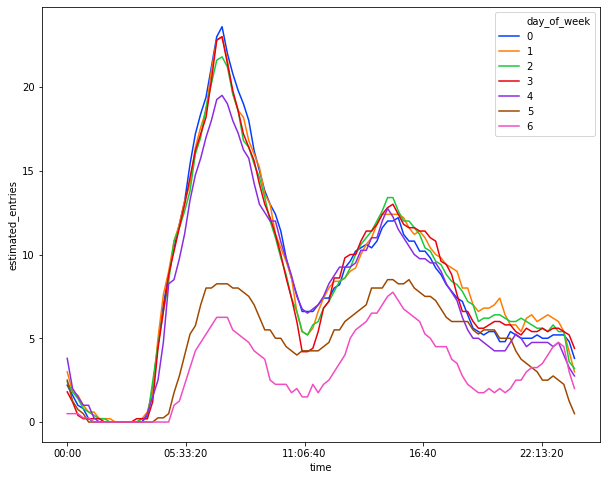

In [847]:
fig,ax = plt.subplots(figsize=(10,8))
sns.lineplot(x='time',y='estimated_entries',hue='day_of_week',data=tsq,ci=None,legend='full',palette='bright')

### Merging with Crosswalk

In [464]:
crosswalk = pd.read_csv('../../data/crosswalk/Master_crosswalk.csv')

In [653]:
jan_weekday['trimmed_trip_id'] = [re.sub(r'.*Weekday.*-\d{2}_','',x) for x in jan_weekday.trip_id]

In [856]:
def get_crowding(avg_turnstile,crosswalk,schedule):
    avg_turnstile = avg_turnstile.merge(crosswalk[['turnstile_station_name','turnstile_lines','gtfs_station_name','gtfs_lines','gtfs_stop_id']],how='outer',left_on=['STATION','LINENAME'],right_on=['turnstile_station_name','turnstile_lines'])
    avg_turnstile = avg_turnstile[avg_turnstile.gtfs_station_name.notnull()]
    avg_turnstile = avg_turnstile[avg_turnstile.STATION.notnull()]
    crowding = avg_turnstile.merge(schedule,how='left',left_on=['gtfs_stop_id','time'],right_on=['trimmed_stop_id','clean_time'])
    crowding.drop(['turnstile_station_name', 'turnstile_lines', 'arrival_time',
       'departure_time','stop_headsign',
       'pickup_type', 'drop_off_type', 'shape_dist_traveled','trimmed_stop_id'],axis=1,inplace=True)
    return crowding

In [858]:
crowding_2019 = get_crowding(avg_turnstile_2019,crosswalk,jan_weekday)
crowding_2020_alt = get_crowding(avg_turnstile_2020,crosswalk,jan_weekday)

In [641]:
crowding[crowding.clean_time.notnull()].head().set_index(['STATION','LINENAME','time']).sort_index()

total_entries  total_exits  \
STATION     LINENAME time                                              
ATLANTIC AV L        1900-01-01 00:09:00            0.0          1.0   
                     1900-01-01 00:19:00            0.0          2.0   
                     1900-01-01 00:39:00            1.0          2.0   
                     1900-01-01 00:49:00            1.0          2.0   
                     1900-01-01 00:59:00            1.0          3.0   

                                         gtfs_station_name gtfs_lines  \
STATION     LINENAME time                                               
ATLANTIC AV L        1900-01-01 00:09:00       Atlantic Av          L   
                     1900-01-01 00:19:00       Atlantic Av          L   
                     1900-01-01 00:39:00       Atlantic Av          L   
                     1900-01-01 00:49:00       Atlantic Av          L   
                     1900-01-01 00:59:00       Atlantic Av          L   

                                         gtfs_stop_id  \
STATION     LINENAME time                               
ATLANTIC AV L        1900-01-01 00:09:00          L24   
                     1900-01-01 00:19:00          L24   
                     1900-01-01 00:39:00          L24   
                     1900-01-01 00:49:00          L24   
                     1900-01-01 00:59:00          L24   

                                                                           trip_id  \
STATION     LINENAME time                                                            
ATLANTIC AV L        1900-01-01 00:09:00  BFA19SUPP-L047-Weekday-99_000100_L..N01R   
                     1900-01-01 00:19:00  BFA19SUPP-L047-Weekday-99_001100_L..N10R   
                     1900-01-01 00:39:00  BFA19SUPP-L047-Weekday-99_003100_L..N10R   
                     1900-01-01 00:49:00  BFA19SUPP-L047-Weekday-99_004100_L..N01R   
                     1900-01-01 00:59:00  BFA19SUPP-L047-Weekday-99_005100_L..N10R   

                                         stop_id  stop_sequence route_id  \
STATION     LINENAME time                                                  
ATLANTIC AV L        1900-01-01 00:09:00    L24N            6.0        L   
                     1900-01-01 00:19:00    L24N            6.0        L   
                     1900-01-01 00:39:00    L24N            6.0        L   
                     1900-01-01 00:49:00    L24N            6.0        L   
                     1900-01-01 00:59:00    L24N            6.0        L   

                                          direction_id          clean_time  
STATION     LINENAME time                                                   
ATLANTIC AV L        1900-01-01 00:09:00           0.0 1900-01-01 00:09:00  
                     1900-01-01 00:19:00           0.0 1900-01-01 00:19:00  
                     1900-01-01 00:39:00           0.0 1900-01-01 00:39:00  
                     1900-01-01 00:49:00           0.0 1900-01-01 00:49:00  
                     1900-01-01 00:59:00           0.0 1900-01-01 00:59:00

In [861]:
routes = crowding.groupby('route_id').max()['stop_sequence'].to_frame().reset_index()

In [870]:
routes = routes[~routes.route_id.isin(['5X','6X','7X','FS','FX','GS','H'])]

In [874]:
routes.reset_index(inplace=True)

In [817]:
def get_trip_counts(df,max_st):
    trip_count = [0] * len(df)
    idx = 0 
    for i,row in df.iterrows():
        if np.isnan(row.entries_since_last_train):
            entered = np.round(row.total_entries*(max_st-row.stop_sequence)/max_st)
        else:
            entered = np.round(row.entries_since_last_train*(max_st-row.stop_sequence)/max_st)
        
        current_count = 0
        if(idx > 0):
            current_count = trip_count[idx-1]
        if np.isnan(row.exits_since_last_train):
            exited = np.round(row.total_exits*(row.stop_sequence-1)/max_st)
            exited = min(row.total_exits,current_count)
        else:
            exited = np.round(row.exits_since_last_train*(row.stop_sequence-1)/max_st)
            exited = min(row.exits_since_last_train,current_count)
        
        if idx>0:
            trip_count[idx] = trip_count[idx-1] + entered - exited
        else:
            trip_count[idx] = trip_count[idx] + entered - exited
#         print(trip_count[idx])
        idx = idx +1
    df['trip_count'] = trip_count
    return df
    

In [876]:
crowding_2019.head()

,STATION,LINENAME,time,total_entries,total_exits,gtfs_station_name,gtfs_lines,gtfs_stop_id,trip_id,stop_id,stop_sequence,route_id,direction_id,clean_time,trimmed_trip_id
0,FLUSHING AV,G,1900-01-01 01:00:00,0.0,9.0,Flushing Av,G,G31,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,FLUSHING AV,G,1900-01-01 03:12:00,0.0,10.0,Flushing Av,G,G31,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,FLUSHING AV,G,1900-01-01 03:10:00,0.0,10.0,Flushing Av,G,G31,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,FLUSHING AV,G,1900-01-01 03:09:00,0.0,10.0,Flushing Av,G,G31,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,FLUSHING AV,G,1900-01-01 03:08:00,0.0,10.0,Flushing Av,G,G31,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [889]:
def get_crowd_by_line(crowding,line,max_st,ax):
    tmp = crowding[(crowding.clean_time.notnull()) & (crowding.route_id == line)].sort_values(['time','stop_sequence']).copy()
    tmp['entries_since_last_train'] = tmp.sort_values('clean_time').groupby('STATION').total_entries.diff()
    tmp['exits_since_last_train'] = tmp.sort_values('clean_time').groupby('STATION').total_exits.diff()
    faulty_station_data = tmp[(tmp.entries_since_last_train < 0)].STATION.unique()
    tmp = crowding[(crowding.clean_time.notnull()) & (crowding.route_id == line) & (~crowding.STATION.isin(faulty_station_data))].sort_values(['time','stop_sequence']).copy()
    tmp['entries_since_last_train'] = tmp.sort_values('clean_time').groupby('STATION').total_entries.diff()
    tmp['exits_since_last_train'] = tmp.sort_values('clean_time').groupby('STATION').total_exits.diff()
    tmp.reset_index(inplace=True)
    tmp = tmp.groupby('trip_id').apply(get_trip_counts,max_st=max_st)
#     tmp = tmp.groupby(['clean_time','direction_id']).mean()['trip_count'].to_frame().resample('15T').asfreq().interpolate().reset_index()
    tmp = tmp.groupby(['clean_time','direction_id']).mean()['trip_count'].to_frame().reset_index()
    sns.lineplot(x='clean_time',y='trip_count',hue='direction_id',data=tmp, ax=ax,legend=False).set_title(line)

### Crowding by line over the day in Apr 2019

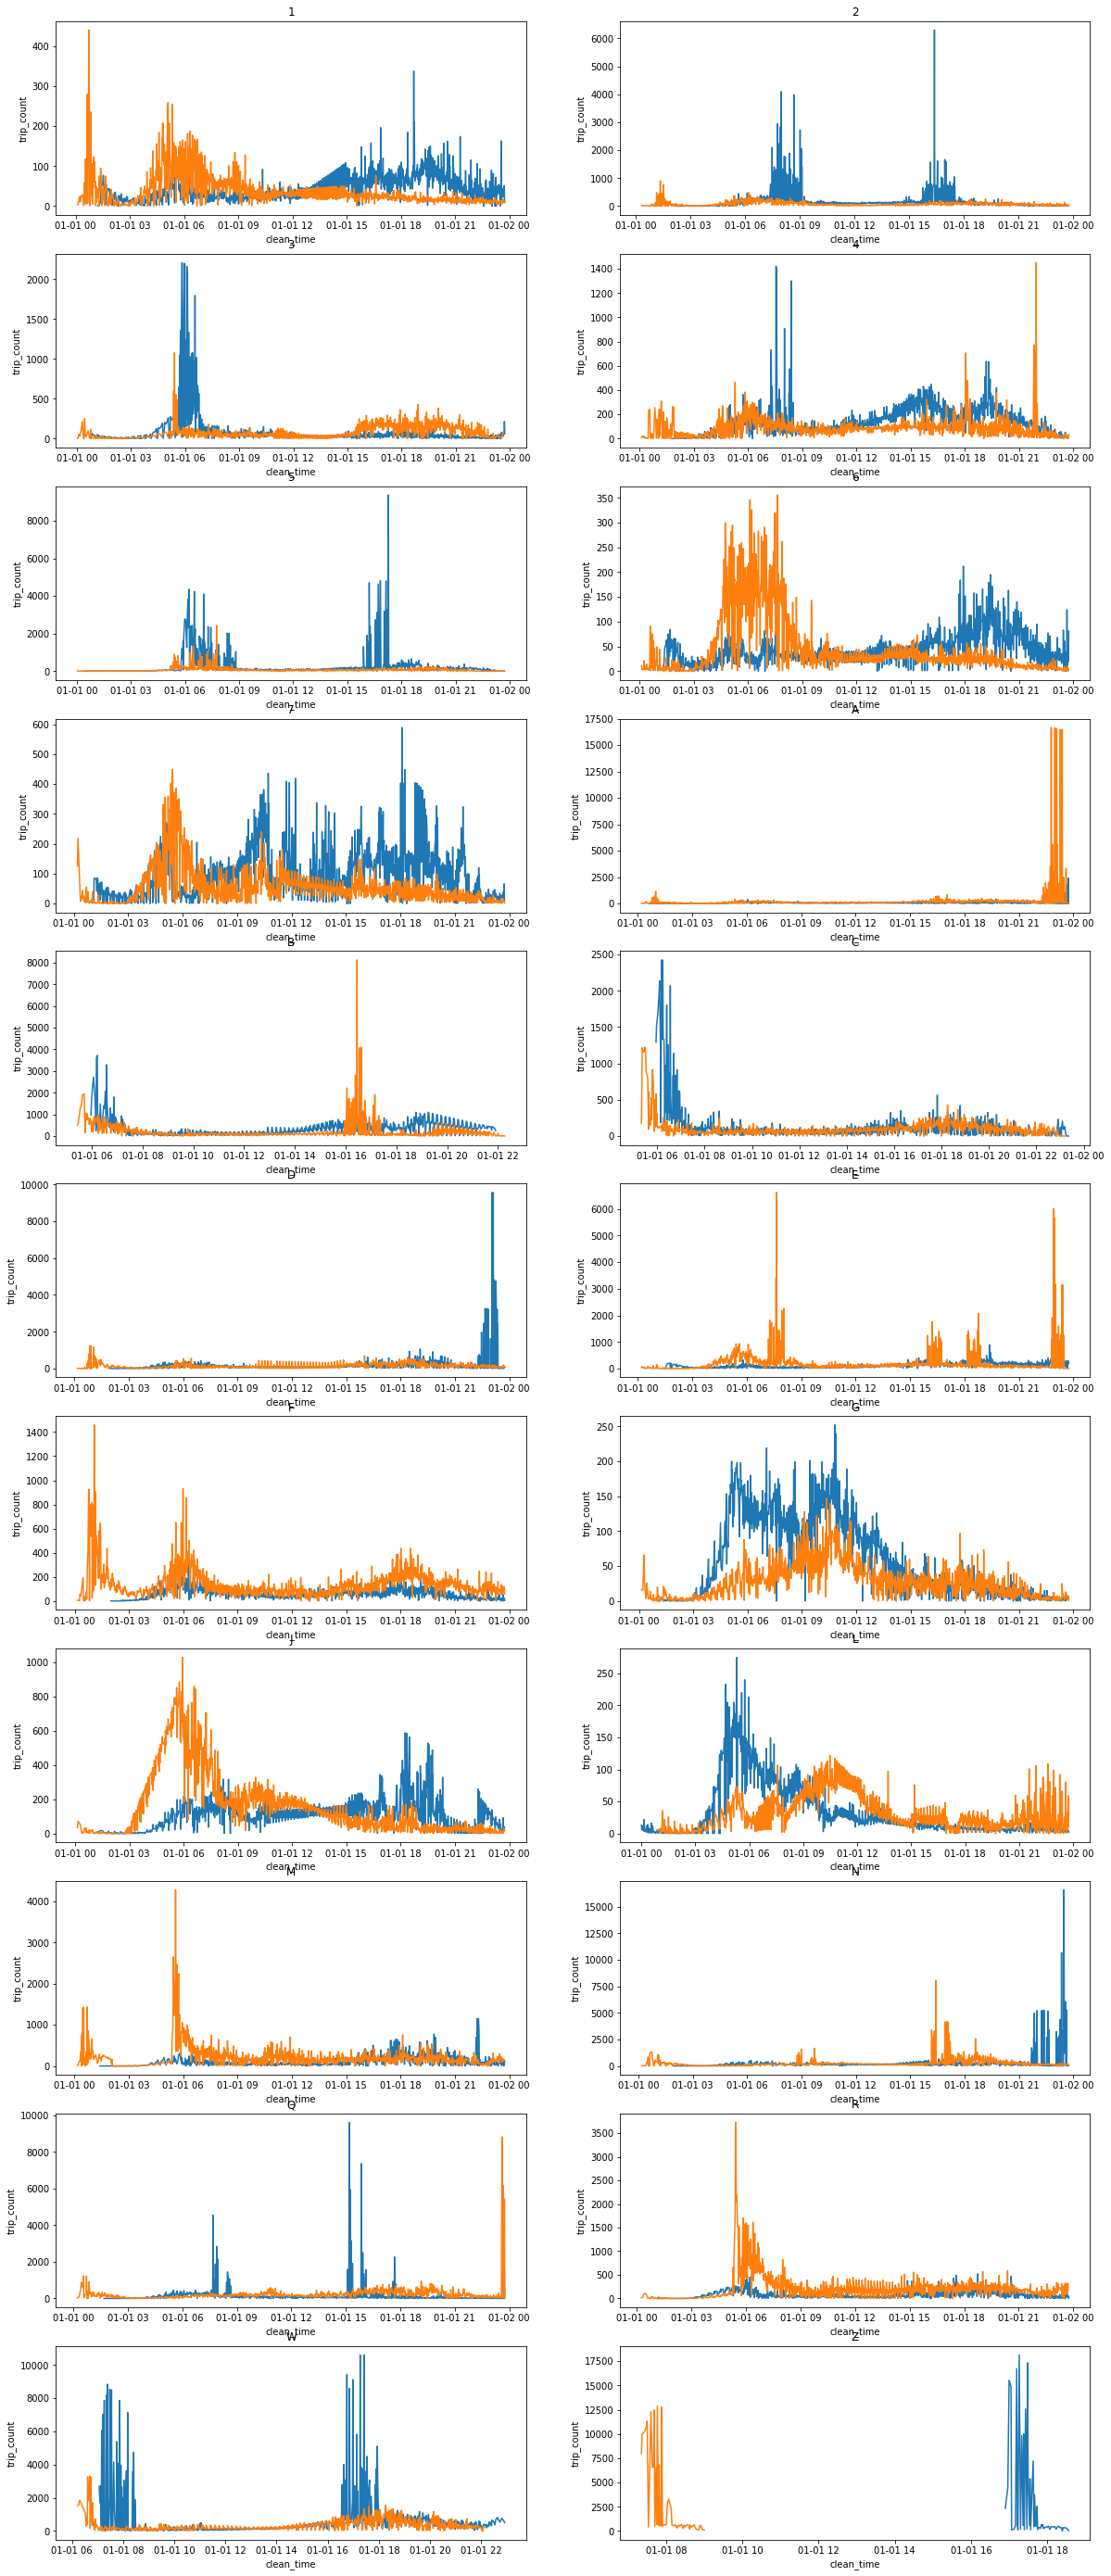

In [896]:
fig,axs = plt.subplots(nrows=11,ncols=2,figsize=(20,50))
for i,row in routes.iterrows():
    x = i // 2
    y = i % 2
    get_crowd_by_line(crowding_2019,row.route_id,row.stop_sequence,ax=axs[x][y])

### Crowding by line over the day in Apr 2020 if schedule didn't change

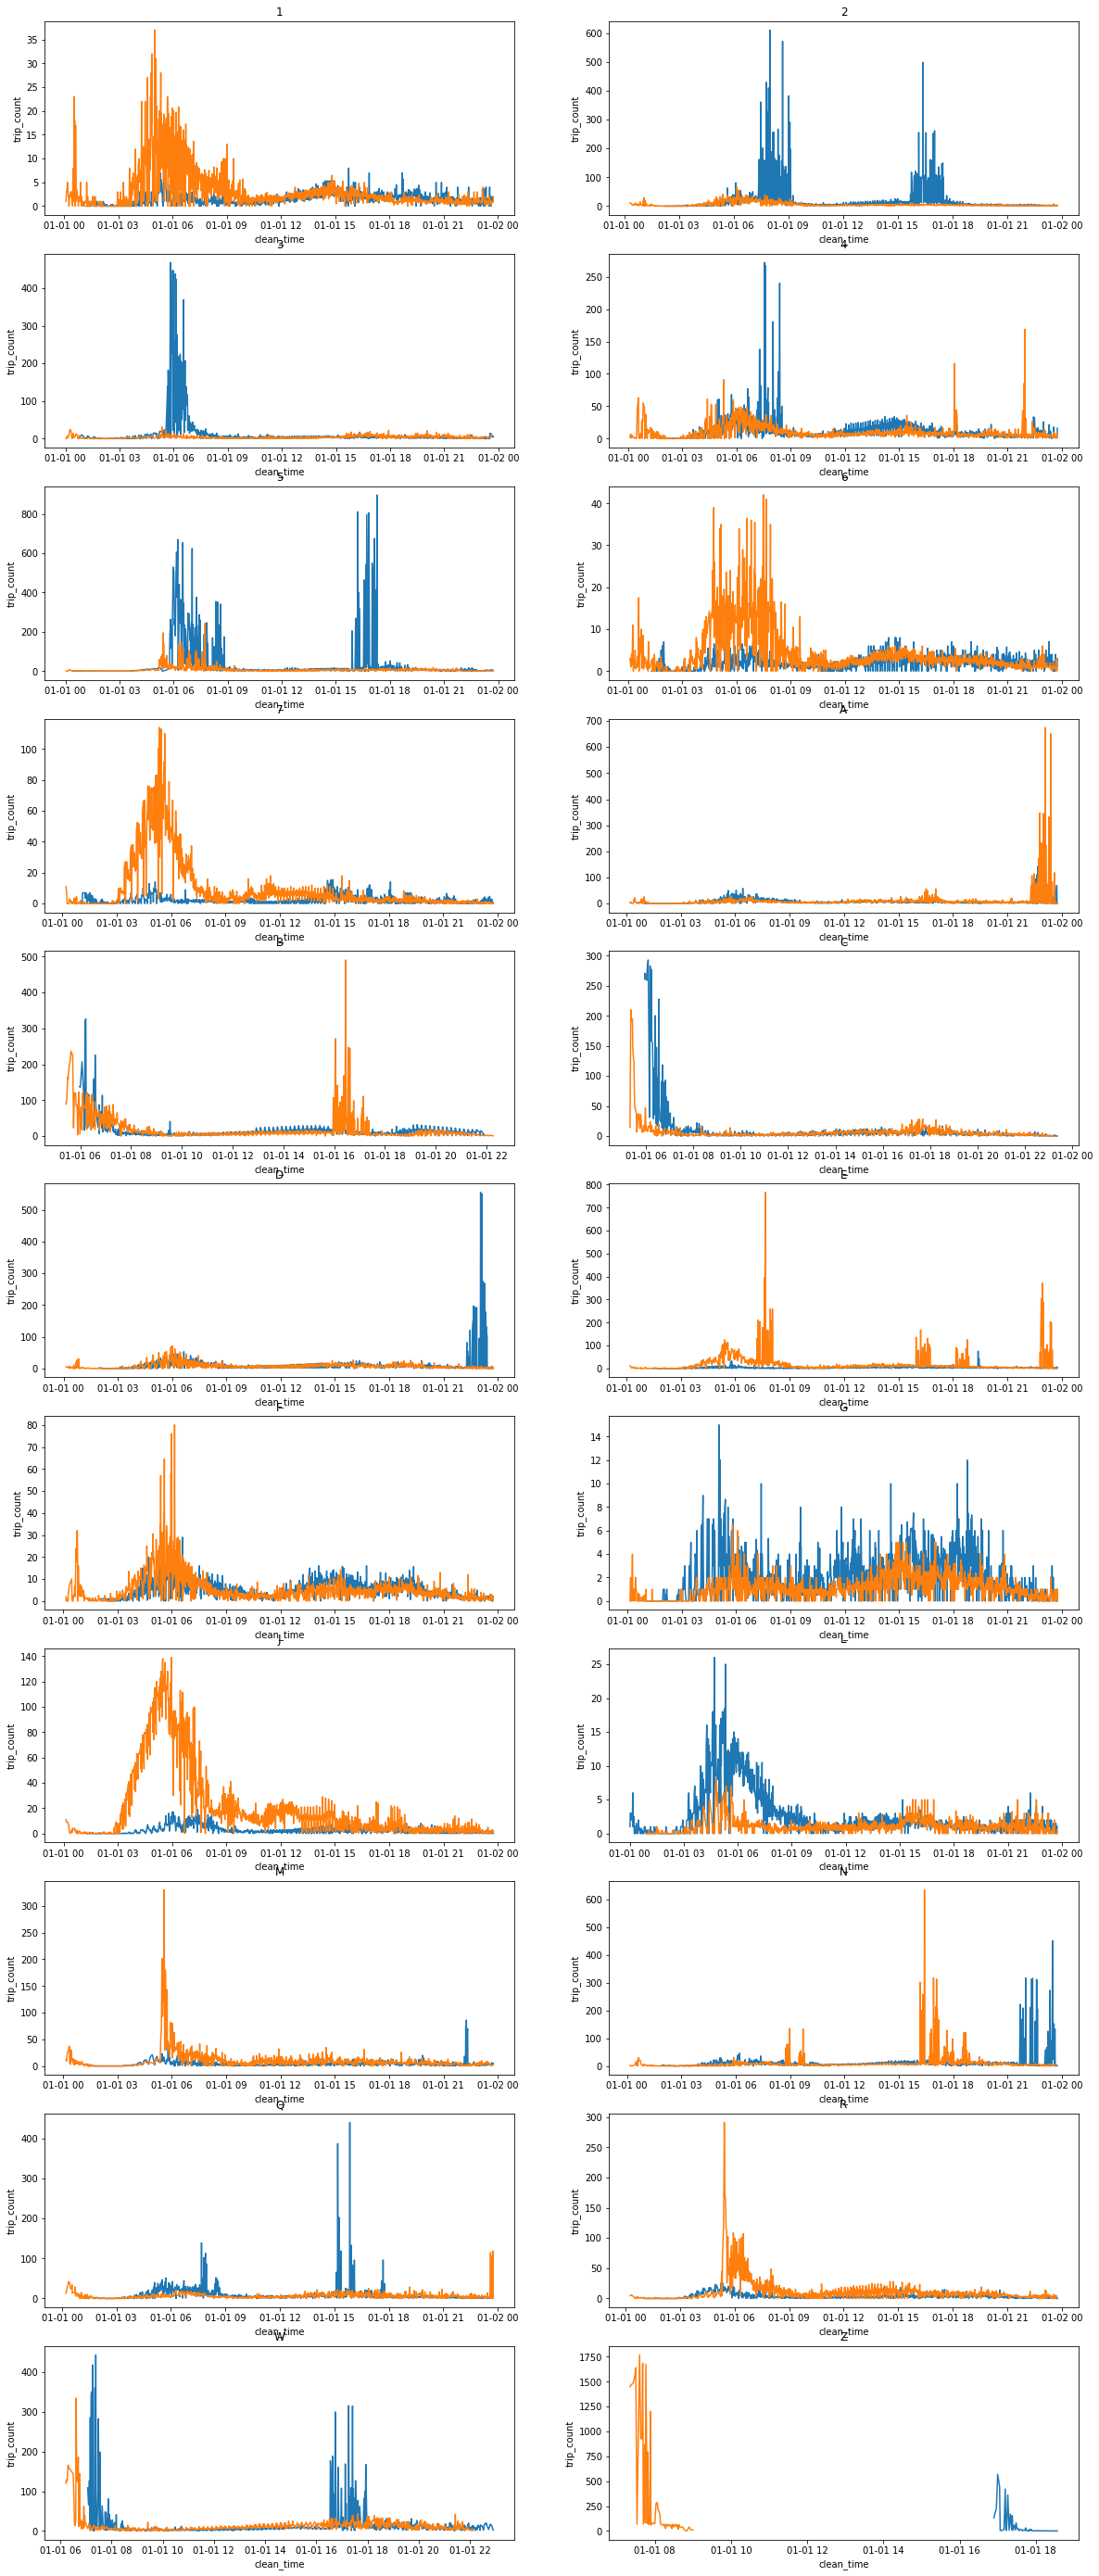

In [897]:
fig,axs = plt.subplots(nrows=11,ncols=2,figsize=(20,50))
for i,row in routes.iterrows():
    x = i // 2
    y = i % 2
    get_crowd_by_line(crowding_2020_alt,row.route_id,row.stop_sequence,ax=axs[x][y])

### Crowding by line over the day in Apr 2020 with schedule change

/opt/conda/envs/mta/lib/python3.8/site-packages/pandas/core/computation/expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


AxesSubplot(0.125,0.125;0.775x0.755)


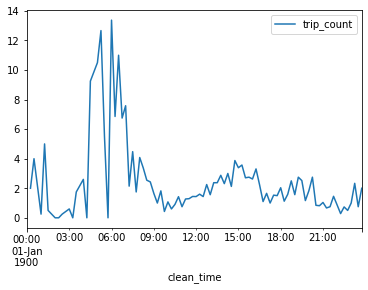

In [833]:
get_crowd_by_line(crowding,'1',38)

In [836]:
5000/50

100.0

/opt/conda/envs/mta/lib/python3.8/site-packages/pandas/core/computation/expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


AxesSubplot(0.125,0.125;0.775x0.755)


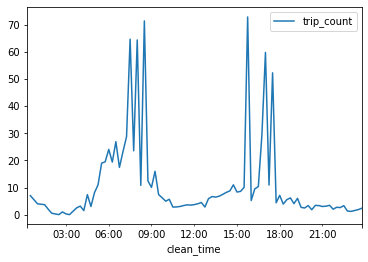

In [834]:
get_crowd_by_line(crowding,'2',61)

/opt/conda/envs/mta/lib/python3.8/site-packages/pandas/core/computation/expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


AxesSubplot(0.125,0.125;0.775x0.755)


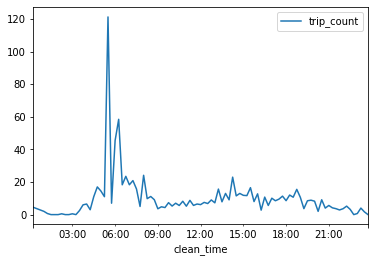

In [835]:
get_crowd_by_line(crowding,'R',61)

- Fix Turnstile gtfs mapping
- Use old turnstile data (Apr 2019)
- Quick fixes for Apr schedule
- Figure out splitting across lines
- Stations x Exits weighting